# Adaptive RAG

* Adaptive RAG is a strategy for RAG that unites by adding a self-correction loop, using an evaluator to check retrieved documents, refining queries, and potentially using web searches to improve the accuracy and relevance of AI-generated answers, preventing "garbage in, garbage out" scenarios

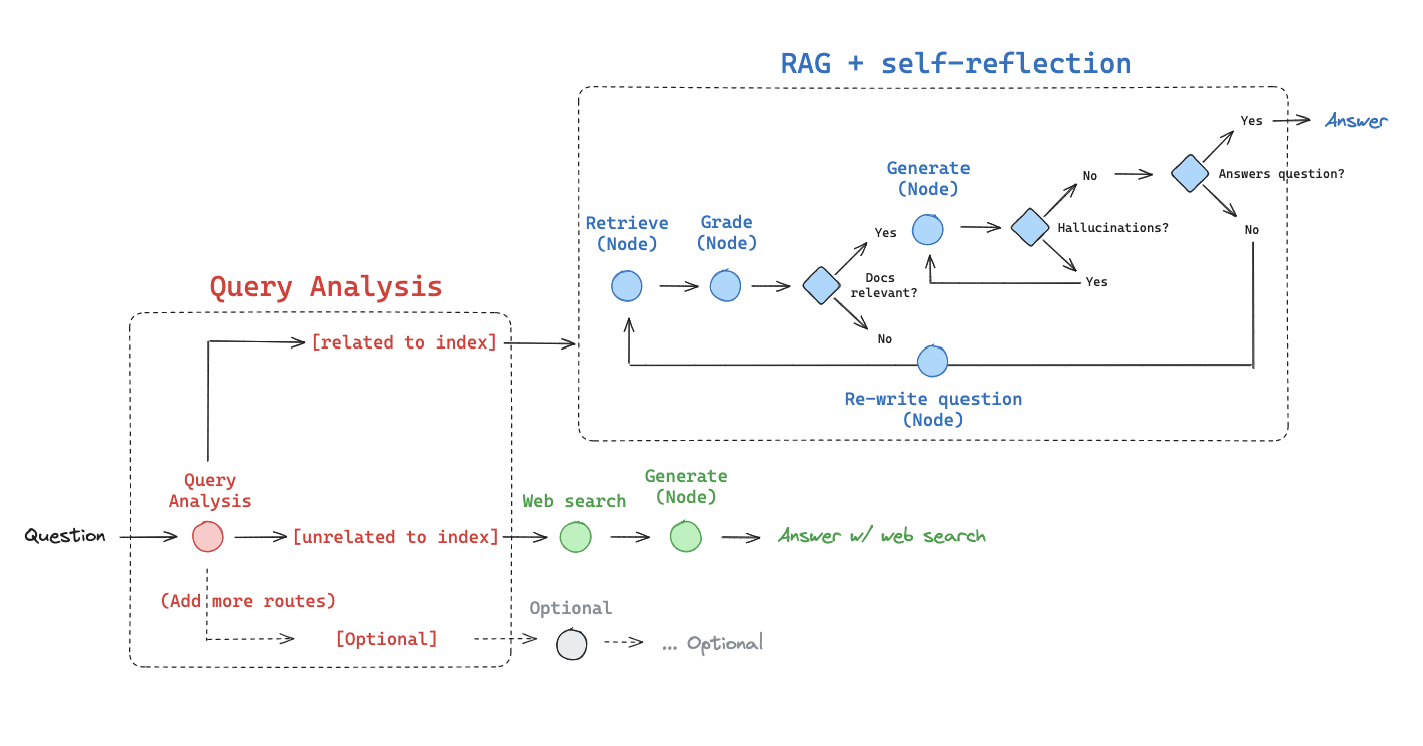

In [24]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["TAVILY_API_KEY"] = "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"

In [25]:
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_classic.document_loaders import WebBaseLoader
from langchain_classic.vectorstores import FAISS
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings

In [26]:
urls=[
    "https://docs.langchain.com/oss/python/langgraph/persistence",
    "https://docs.langchain.com/oss/python/langgraph/durable-execution",
    "https://docs.langchain.com/oss/python/langgraph/interrupts",
    "https://docs.langchain.com/oss/python/langgraph/add-memory"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


[[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/persistence', 'title': 'Persistence - Docs by LangChain', 'language': 'en'}, page_content='Persistence - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...⌘KSupportGitHubTry LangSmithTry LangSmithSearch...NavigationCapabilitiesPersistenceLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartLocal serverChangelogThinking in LangGraphWorkflows + agentsCapabilitiesPersistenceDurable executionStreamingInterruptsTime travelMemorySubgraphsProductionApplication structureTestLangSmith StudioAgent Chat UILangSmith DeploymentLangSmith ObservabilityLangGraph APIsGraph APIFunctional APIRuntimeOn this pageThreadsCheckpointsGet stateGet state historyReplayUpdate stateconfigvaluesas_nodeMemory storeBasic usageSemantic searchUsing in LangGraphCheckpointer librariesCheckpointer interfaceSerializerSerialization with pickleEncrypt

In [27]:
docs_list=[item for sublist in docs for item in sublist]
docs_list

[Document(metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/persistence', 'title': 'Persistence - Docs by LangChain', 'language': 'en'}, page_content='Persistence - Docs by LangChainSkip to main contentDocs by LangChain home pageLangChain + LangGraphSearch...⌘KSupportGitHubTry LangSmithTry LangSmithSearch...NavigationCapabilitiesPersistenceLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewGet startedInstallQuickstartLocal serverChangelogThinking in LangGraphWorkflows + agentsCapabilitiesPersistenceDurable executionStreamingInterruptsTime travelMemorySubgraphsProductionApplication structureTestLangSmith StudioAgent Chat UILangSmith DeploymentLangSmith ObservabilityLangGraph APIsGraph APIFunctional APIRuntimeOn this pageThreadsCheckpointsGet stateGet state historyReplayUpdate stateconfigvaluesas_nodeMemory storeBasic usageSemantic searchUsing in LangGraphCheckpointer librariesCheckpointer interfaceSerializerSerialization with pickleEncrypti

In [28]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=1000,chunk_overlap=200)
embeddings=HuggingFaceEmbeddings(model="all-MiniLM-L6-v2")
llm=ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
llm.invoke("hi")

AIMessage(content='Hi! How are you today? Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 11, 'total_tokens': 34, 'completion_time': 0.052013345, 'prompt_time': 5.1359e-05, 'queue_time': 0.04357205, 'total_time': 0.052064704}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_ba95244fa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--fa4dadab-aeaa-4275-bfe5-e6027e89fb5a-0', usage_metadata={'input_tokens': 11, 'output_tokens': 23, 'total_tokens': 34})

In [29]:
doc_splits=text_splitter.split_documents(docs_list)

vector_store=FAISS.from_documents(doc_splits,embeddings)

retriever=vector_store.as_retriever()

In [30]:
retriever.invoke("what is ai")

[Document(id='8f9c60e7-e39d-4129-b83b-28ae5571492b', metadata={'source': 'https://docs.langchain.com/oss/python/langgraph/persistence', 'title': 'Persistence - Docs by LangChain', 'language': 'en'}, page_content='# ... Define the graph ...\n\n# Compile the graph with the checkpointer and store\ngraph = graph.compile(checkpointer=checkpointer, store=in_memory_store)\n\nWe invoke the graph with a thread_id, as before, and also with a user_id, which we’ll use to namespace our memories to this particular user as we showed above.\nCopy# Invoke the graph\nuser_id = "1"\nconfig = {"configurable": {"thread_id": "1", "user_id": user_id}}\n\n# First let\'s just say hi to the AI\nfor update in graph.stream(\n    {"messages": [{"role": "user", "content": "hi"}]}, config, stream_mode="updates"\n):\n    print(update)\n\nWe can access the in_memory_store and the user_id in any node by passing store: BaseStore and config: RunnableConfig as node arguments. Here’s how we might use semantic search in a n

In [31]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate

from pydantic import BaseModel, Field

#### GRAPH STATE

In [32]:
from typing_extensions import TypedDict,List
class GraphState(TypedDict):
    " Represents the state of our graph"

    question: str
    generation: str
    documents: List[str]


In [33]:

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

#### WEB SEARCH NODE

In [34]:
from langchain_classic.schema import Document
def web_search(state):

    "web search based on the query"

    print("---WEB SEARCH---")
    question=state["question"]

    docs=web_search_tool.invoke({"query":question})

    web_results="\n".join([d["content"] for d in docs])
    web_results=Document(page_content=web_results)

    return {"documents":web_results,"question":question}


#### RETRIEVE NODE

In [35]:
def retrieve(state):
    "Retrieve documents from the vector store"

    print("---RETRIEVE---")

    question=state["question"]

    documents=retriever.invoke(question)

    return{"documents":documents,"question":question}
    

In [36]:
from langsmith import Client
client = Client()
prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)


rag_chain=prompt|llm

#### RESPONSE GENERATE NODE

In [37]:
def generate(state):
    "Generate answer for the user query"

    print("---GENERATE---")
    question=state["question"]
    documents=state["documents"]

    new_docs=rag_chain.invoke({"context":documents,"question":question})

    return {"generation":new_docs}

#### GRADING DOCUCMENTS NODE

In [38]:
def grade_docs(state):
    "Determine whether the retrieved documents are relevant to the quetion or not"

    print("---GRADING DOCMENTS---")

    class GradeDocuments(BaseModel):
        """Binary score for relevance check on retrieved documents."""

        binary_score: str = Field(
            description="Documents are relevant to the question, 'yes' or 'no'"
        )

    structured_llm_grader = llm.with_structured_output(GradeDocuments)

    # Prompt
    system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )

    retrieval_grader = grade_prompt | structured_llm_grader

    question=state["question"]
    documents=state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


#### REWRITE QUERY NODE

In [39]:
def rewrite_query(state):

    "Rewrite query to produce a better question"

    print("---REWRITE QUERY---")

    system = """You are a query rewriting agent.

        Rewrite the user's question to a SHORT, SEARCH-OPTIMIZED QUESTION.

        RULES:
        - Return ONLY the rewritten question.
        - DO NOT add explanations.
        - DO NOT say "based on the original question".
        - DO NOT create paragraphs.
        - NO formatting.
        - NO markdown.
        - ONLY return the rewritten question, nothing else.
        """
    re_write_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            (
                "human",
                "Here is the initial question: \n\n {question} \n Formulate an improved question.",
            ),
        ]
    )


    question=state["question"]
    documents=state["documents"]
    
    question_rewriter = re_write_prompt | llm 

    better_question = question_rewriter.invoke({"question": question})
    print(better_question.content)
    return {"documents": documents, "question": better_question.content}

#### QUERY ANALYSIS NODE

In [40]:
def query_analysis(state):

    " analyse the query to route web search or RAG"

    print("---ROUTE QUESTION---")

    class RouteQuery(BaseModel):
        """Route a user query to the most relevant datasource."""

        datasource: Literal["vectorstore", "web_search"] = Field(
            ...,
            description="Given a user question choose to route it to web search or a vectorstore.",
        )

    structured_llm_router = llm.with_structured_output(RouteQuery)

    # Prompt
    system = """You are an expert at routing a user question to a vectorstore or web search.
    The vectorstore contains documents related to langgraph capabilities such as perisitence, durable execution, interrupts and memory.
    Use the vectorstore for questions on these topics. Otherwise, use web-search."""
    route_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "{question}"),
        ]
    )

    question_router = route_prompt | structured_llm_router

    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


#### CHECKING DOCUMENT RELEVANCE (ROUTING NODE)

In [41]:
def docs_relevant(state):
    "Determines whether to generate an answer, or re-generate a question."

    print("---CHECKING DOCUMENTS RELEVANCE---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "irrelevant"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "relavent"


#### CHECKING FOR HALLUCINATION (ROUTING NODE) 

In [42]:
def hallucination(state):
    "Determines whether the generation is grounded in the document and answers question."

    print("---CHECK HALLUCINATIONS---")
    ### Hallucination Grader
    # Data model
    class GradeHallucinations(BaseModel):
        """Binary score for hallucination present in generation answer."""

        binary_score: str = Field(
            description="Answer is grounded in the facts, 'yes' or 'no'"
        )

    structured_llm_grader = llm.with_structured_output(GradeHallucinations)

    # Prompt
    system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
        Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
    hallucination_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
        ]
    )

    hallucination_grader = hallucination_prompt | structured_llm_grader
    

    ### Answer Grader
    # Data model
    class GradeAnswer(BaseModel):
        """Binary score to assess answer addresses question."""

        binary_score: str = Field(
            description="Answer addresses the question, 'yes' or 'no'"
        )


    # LLM with function call
    structured_llm_grader = llm.with_structured_output(GradeAnswer)

    # Prompt
    system = """You are a grader assessing whether an answer addresses / resolves a question \n 
        Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
    answer_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
        ]
    )

    answer_grader = answer_prompt | structured_llm_grader
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})

    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not_useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "hallucinate"




In [43]:
from langgraph.graph import StateGraph,START,END

builder=StateGraph(GraphState)

builder.add_node("web_search",web_search)
builder.add_node("retrieve",retrieve)
builder.add_node("generate",generate)
builder.add_node("grade_docs",grade_docs)
builder.add_node("rewrite_query",rewrite_query)

builder.add_conditional_edges(START,query_analysis,{"web_search":"web_search",
                                                    "vectorstore":"retrieve"})

builder.add_edge("web_search","generate")

builder.add_edge("retrieve","grade_docs")

builder.add_conditional_edges("grade_docs",docs_relevant,{"relavent":"generate","irrelevant":"rewrite_query"})

builder.add_edge("rewrite_query","retrieve")

builder.add_conditional_edges("generate",hallucination,{"hallucinate":"generate",
                                                        "useful":END,
                                                        "not_useful":"rewrite_query"})

graph=builder.compile()

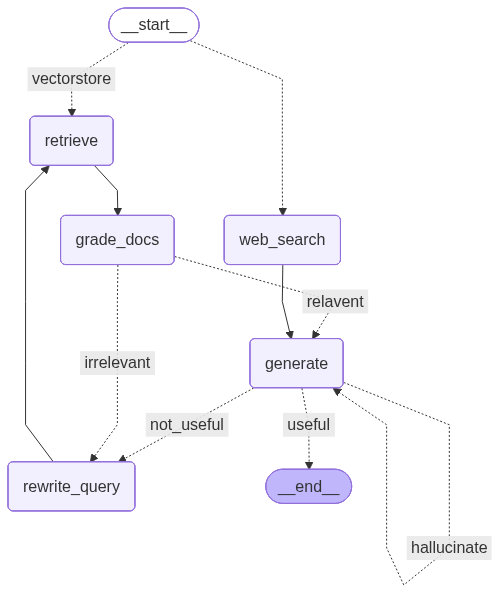

In [44]:
from IPython.display import display,Image

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [45]:
graph.invoke({"question":"what are interrupts"},config={"recursion_limit": 10})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---GRADING DOCMENTS---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---CHECKING DOCUMENTS RELEVANCE---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'what are interrupts',
 'generation': AIMessage(content='Interrupts allow you to pause graph execution at specific points and wait for external input before continuing. They are dynamic, can be placed anywhere in your code, and can be conditional based on your application logic. Interrupts work by calling the `interrupt()` function at any point in your graph nodes, which saves the graph state and waits for you to resume execution.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 3738, 'total_tokens': 3811, 'completion_time': 0.18724286, 'prompt_time': 0.127138424, 'queue_time': 0.217698411, 'total_time': 0.314381284}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--7bd84409-fa19-45bc-9f58-f848f462f033-0', usage_metadata={'input_tokens': 3738, 'output_tokens': 73, 